In [24]:
import numpy
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pprint as pp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

from dynamicalsystems import SimplePendulum
from regression import PolynomialLibrary, TrigLibrary

In [25]:
class SINDy(nn.Module):
    def __init__(
        self,
        X, 
        X_dot=None, 
        libs=None, 
        feature_names=None
    ):
        super(SINDy, self).__init__()

        n,m = X.size()
        if feature_names == None:
            feature_names = [f'x{i+1}' for i in range(m)]

        self.X = X
        self.X_dot = X_dot
        self.feature_names = feature_names
        self.num_features  = m
        self.num_snapshots = n

        self.candidate_terms = [ lambda x: torch.ones(self.num_snapshots) ]
        self.candidate_names = ['1']
        for lib in libs:
            lib_candidates = lib.get_candidates(self.num_features, feature_names)
            for term, name in lib_candidates:
                self.candidate_terms.append(term)
                self.candidate_names.append(name)

        self.SINDy_forward = nn.Linear(
            len(self.candidate_terms), 
            self.num_features, 
            bias=False
        )
        
    def library(self):
        print('library candidate terms:')
        return self.candidate_names
    
    def model_parameters(self):
        params = list(self.parameters())[0]
        return params
    
    def theta(self,X):
        return torch.stack(tuple(f(X) for f in self.candidate_terms), axis=1)

    def forward(self):
        theta_X = self.theta(self.X)
        
        # X_dot_predict = f(X) = Θ(X)Ξ = Θ(X)[ ξ1, ξ2, ..., ξn ]
        X_dot_predict = self.SINDy_forward(theta_X)
        return X_dot_predict

In [26]:
sp = SimplePendulum(g=9.8,l=2,mu=0.5,theta0=np.pi/2) # Simple Pendulum simulated in state space

sp.embed(n=10,mat='RANDN',mu=0,sigma=0.0) #embed the pendulum in a higer diminsional space with noise

In [27]:
data = sp.to_torch() #get the torch tensors

print(list(data)) # U and dU are the state space representation theta while X and dX are embeded they are our transformed data 

['U', 'dU', 'X', 'dX']


In [20]:
#data['X'] is the X data
#data['dX'] is the dX computed from f(t,x)
#data['U'] and data['dU'] are the ground truth of the dynamical system in [theta, thetadot] state space
print(data['X'][0:300:100,:]) 
print(data['dX'][0:300:100,:])
print(data['U'][0:300:100,:])
print(data['dU'][0:300:100,:])

tensor([[ 0.5078, -0.7740,  1.4034,  2.2963, -3.2695, -0.2759,  0.7697, -2.9102,
          1.1880,  0.2308],
        [-0.3477,  0.1712,  3.9977, -1.6840, -2.0394, -0.6260,  1.1466, -1.0190,
          6.1898, -0.4167],
        [-0.0800,  0.3261, -3.0418, -0.2983,  2.9488,  0.5071, -1.0734,  2.1718,
         -4.1710,  0.1108]])
tensor([[-0.5653,  0.1233,  8.6407, -2.7861, -5.1632, -1.3697,  2.5870, -2.9573,
         13.0877, -0.7892],
        [-0.5059,  1.1159, -6.1616, -2.1805,  7.3672,  1.0577, -2.3747,  5.7925,
         -7.9111,  0.0186],
        [ 0.7371, -0.7328, -3.3636,  3.4550, -0.0865,  0.4871, -0.7056, -0.9443,
         -5.9033,  0.6168]])
tensor([[ 1.5708,  0.0000],
        [-0.2258, -2.3814],
        [-0.7309,  1.3546]])
tensor([[ 0.0000, -4.9000],
        [-2.3814,  2.2876],
        [ 1.3546,  2.5938]])


In [28]:
libs = [ PolynomialLibrary(max_degree=1), TrigLibrary() ]

sindy = SINDy(
    data['U'],
    X_dot = data['dU'],
     libs=libs,
     feature_names=['x', 'y']
)

In [30]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.libs = [ PolynomialLibrary(max_degree=1), TrigLibrary() ]

        self.encoder = nn.Sequential(
            nn.Linear(10, 8),
            nn.ReLU(),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Linear(4, 2) # -> N, 3
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(2,4),
            nn.ReLU(),
            nn.Linear(4,8),
            nn.ReLU(),
            nn.Linear(8,10)
        )

    def forward(self, x, dx):
        Z = self.encoder(x)
        dZ = self.get_dZ(x,dx)
        X_pred = self.decoder(Z)
        dZ_pred = self.sindy(Z) #HW parker
        Xi = None # Hw parker
        dX_pred = self.get_dX(Z) #HW audrey
        return { 'X' : x, 'dX' : dx,'X_pred' : X_pred, 'dZ_pred' : dZ_pred, 'Z' : Z, 'dZ' : dZ, 'Xi' : Xi}
    def get_dZ(self,x,dx):
        J = torch.autograd.functional.jacobian(self.encoder, x)
        return torch.matmul(J.T,dx)
 
    # def get_dX(self,z,dz):
    #     J = torch.autograd.functional.jacobian(self.decoder, z)
    #     return torch.matmul(J.T,dz)

    def sindy(self,Z): #HW 1
        Z_dot_pred = ...
        return Z_dot_pred

    def loss(self,args):
        return torch.linalg.norm(args['X'] - args['X_pred']) 
            + torch.linalg.norm(args['dZ_pred'] - args['dZ'])
            + torch.linalg.norm(args['dX_pred'] - args['dX'])
            + torch.linalg.norm(args['Xi'],ord=1)

In [31]:
model = Autoencoder()

optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

In [32]:
model.forward(data['X'])

tensor([[ 0.0109,  0.1931,  0.0431,  ...,  0.5645, -0.5122, -0.0158],
        [ 0.0109,  0.1931,  0.0432,  ...,  0.5645, -0.5120, -0.0158],
        [ 0.0108,  0.1931,  0.0432,  ...,  0.5644, -0.5119, -0.0159],
        ...,
        [ 0.0097,  0.1928,  0.0434,  ...,  0.5639, -0.5096, -0.0164],
        [ 0.0097,  0.1928,  0.0434,  ...,  0.5639, -0.5096, -0.0164],
        [ 0.0097,  0.1928,  0.0434,  ...,  0.5639, -0.5096, -0.0164]],
       grad_fn=<AddmmBackward0>)

In [33]:
# Point to training loop video
num_epochs = 100
#outputs = []
losses = []

for epoch in range(num_epochs):
    # #recon = model(data['X'])
    #     z = self.encoder(x)
    #     #dz = self.get_dZ(x,dx)
    #     x_pred = self.decoder(z)
    #     #dx_pred = self.get_dX(z,dz)
    #     return torch.norm(x-x_pred)#+torch.norm(dx_pred-dx)  
    loss = model.loss(data['X'],data['dX'])
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #outputs.append((epoch, data['X'], recon))
    #print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    losses.append(loss.item())

Text(0.5, 1.0, 'log loss')

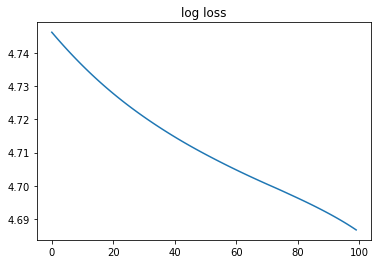

In [34]:
plt.plot(np.log(np.array(losses)))
plt.title("log loss")

In [10]:
x = data['dX'][0:20,:]
dx = data['dX'][0:20,:]

z = model.encoder(x)
dz = model.get_dZ(x,dx)

In [11]:
z

tensor([[-3.6713,  4.4534],
        [-3.6648,  4.4461],
        [-3.6584,  4.4388],
        [-3.6520,  4.4316],
        [-3.6457,  4.4244],
        [-3.6394,  4.4172],
        [-3.6330,  4.4100],
        [-3.6266,  4.4028],
        [-3.6202,  4.3955],
        [-3.6138,  4.3882],
        [-3.6073,  4.3808],
        [-3.6007,  4.3733],
        [-3.5939,  4.3656],
        [-3.5866,  4.3573],
        [-3.5790,  4.3488],
        [-3.5713,  4.3400],
        [-3.5633,  4.3309],
        [-3.5550,  4.3216],
        [-3.5465,  4.3118],
        [-3.5375,  4.3016]], grad_fn=<AddmmBackward0>)

In [12]:
z.shape

torch.Size([20, 2])

In [13]:
dz.shape

torch.Size([10, 20, 2, 10])

In [14]:
dZ = model.get_dZ(dx)

TypeError: get_dZ() missing 1 required positional argument: 'dx'

In [ ]:
dZ.shape

In [ ]:
_z = Z.detach().numpy()
plt.plot(_z[:,0],_z[:,1])
plt.title("Z")

In [ ]:
x = data['X'][0,:]
dx = data['dX'][0,:]
z = model.encoder(x).detach().numpy().reshape(-1,1)

J = torch.autograd.functional.jacobian(model.encoder, dx).detach().numpy()

dz = np.dot(J.T,z)

print(dz.shape)

In [ ]:
x = data['X'][0,:]
dx = data['dX'][0,:]
z = model.encoder(x)

J = torch.autograd.functional.jacobian(model.encoder, dx)

print(z.shape)
print(J.shape)
dz = torch.matmul(J.T,z)


In [ ]:
X = torch.Tensor(sp.Z.T)
recon = model(X)

In [ ]:
recon

In [ ]:
class SINDy(nn.Module):
    def __init__(
        self,
        X, 
        X_dot=None, 
        libs=None, 
        feature_names=None
    ):
        super(SINDy, self).__init__()

        n,m = X.size()
        if feature_names == None:
            feature_names = [f'x{i+1}' for i in range(m)]

        self.X = X
        self.X_dot = X_dot
        self.feature_names = feature_names
        self.num_features  = m
        self.num_snapshots = n

        self.candidate_terms = [ lambda x: torch.ones(self.num_snapshots) ]
        self.candidate_names = ['1']
        for lib in libs:
            lib_candidates = lib.get_candidates(self.num_features, feature_names)
            for term, name in lib_candidates:
                self.candidate_terms.append(term)
                self.candidate_names.append(name)

        self.SINDy_forward = nn.Linear(
            len(self.candidate_terms), 
            self.num_features, 
            bias=False
        )
        
    def library(self):
        print('library candidate terms:')
        return self.candidate_names
    
    def model_parameters(self):
        params = list(self.parameters())[0]
        return params
    
    def theta(self,X):
        return torch.stack(tuple(f(X) for f in self.candidate_terms), axis=1)

    def forward(self):
        theta_X = self.theta(self.X)
        
        # X_dot_predict = f(X) = Θ(X)Ξ = Θ(X)[ ξ1, ξ2, ..., ξn ]
        X_dot_predict = self.SINDy_forward(theta_X)
        return X_dot_predict

In [ ]:
# # 
# t = torch.linspace(0,2,100)

# x = 10 * torch.exp(- 0.5 * t)
# y = -2 * torch.exp(3 * t)

# x_dot = - 0.5 * x
# y_dot = 3 * y

# X = torch.stack((x,y), dim=-1)
# X_dot = torch.stack((x_dot,y_dot), dim=-1)
# X[:5]

# X_dot[:5,:]
# ###################################################################################




# libs  = [
#   PolynomialLibrary(max_degree=1),
#   TrigLibrary()
# ]

# sindy = SINDy(
#     X, 
#     X_dot=X_dot, 
#     libs=libs,
#     feature_names=['x', 'y']
# )

# print(sindy.library())
# print(sindy.model_parameters())

In [ ]:
# norm_2 = lambda X: torch.linalg.norm(X)

# loss_fn = lambda X, X_pred: norm_2(X - X_pred)
# optimizer = torch.optim.Adam(sindy.parameters(), lr=1e-3)

In [ ]:
# epochs = 10000

# for t in range(epochs):
    
#     X_dot_pred = sindy()
#     loss = loss_fn(X_dot, X_dot_pred)
    
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
    
#     if t % 1000 == 0:
#         print(loss)

# print(sindy.library())
# sindy.model_parameters()

In [ ]:
# x1 = torch.tensor([
#     [1,2],
#     [3,4]
# ])
# x2 = x1 * 10
# [*x for x in [x1,x2]]